In [ ]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import math
import random
import json

class DQRAPEnvironment:
    def __init__(self, n_nodes, contention_slots=3, tx_power=24.75, rx_power=13.5, lis_power =13.5, sleep_power=0.015, transmission_rate=None):
        self.n_nodes = n_nodes
        self.contention_slots = contention_slots  # Typically set to 3
        self.tx_power = tx_power
        self.rx_power = rx_power
        self.lis_power = lis_power
        self.sleep_power = sleep_power
        self.dtq = deque()  # Data Transmission Queue
        self.crqs = [deque() for _ in range(contention_slots)]  # Separate Collision Resolution Queues for each minislot
        self.nrq = deque()  # Next Round Queue
        self.max_dtq_length = 0 # Max length for Collision Resolution Queue
        self.transmission_rate = transmission_rate # Transmission rate for each IoT node per round
        self.state = None
        self.transmitted_array = deque()
        self.len_ = deque()
        self.delay_per_timeslot = []
        self.t_sar_per_timeslot = []
        self.packet_entry_times = {}  # To track when each packet enters contention
        self.t_sar_entry_times = {} # To track when each packet successfull contention
        self.packet_delays = []  # To store delays for successfully transmitted packets
        self.current_round = 0
        self.avg_transmitted_array = None
        self.count_transmitted_node = 0
        self.plot_total_delay = {}
        self.input_rate = 0
        self.reset()
        self.trial_all = 1
        self.rounds = 500
        self.new_active_node = []
        self.delay_array= [100,200,300,400]
        self.removed_nodes_history = []  # Track number of removed nodes per timeslot
        self.unique_counter = 0
        self.unique_counter_t_sar = 0
        
    def reset(self):
        self.dtq.clear()
        self.nrq.clear()
        for crq in self.crqs:
            crq.clear()
        return self.state

    def contention_phase(self):
        active_nodes = []
        # First, check if all CRQs are empty
        if all(len(crq) == 0 for crq in self.crqs):
            # If all CRQs are empty, nodes in NRQ can attempt transmission with new nodes
            active_nodes.extend(self.nrq)
            self.nrq.clear()
            # Each node decides whether to attempt transmission based on the transmission rate
            new_active_nodes = [i for i in range(1, self.n_nodes + 1) if np.random.rand() < self.transmission_rate]
            # Track entry time for new packets when they first enter the system
            for node in new_active_nodes:
                if node not in self.packet_entry_times:
                    unique_key = (node, self.unique_counter)
                    self.save_round = self.current_round
                    self.packet_entry_times[unique_key] = self.current_round
                    self.unique_counter += 1  
            active_nodes.extend(new_active_nodes)
        else:
            # If any CRQ is not empty, move new nodes to NRQ for the next round
            new_active_nodes = [i for i in range(1, self.n_nodes + 1) if np.random.rand() < self.transmission_rate]
            # Track entry time for nodes going to NRQ
            for node in new_active_nodes:
                if node not in self.packet_entry_times:
                    unique_key = (node, self.unique_counter)
                    self.packet_entry_times[unique_key] = self.current_round
                    self.unique_counter += 1  
            self.nrq.extend(new_active_nodes)

        # Add nodes from the highest priority CRQ (minislot 1) to attempt contention again
        for i in range(self.contention_slots):
            if self.crqs[i]:
                active_nodes.extend(self.crqs[i].popleft())
                break  # Only handle one CRQ at a time based on priority
        # print(f"Nodes attempting to send: {active_nodes}")
        # Each active node randomly selects a slot
        slots = np.zeros(self.contention_slots)
        node_slots = np.random.randint(0, self.contention_slots, len(active_nodes))

        minislot_assignments = {i: [] for i in range(self.contention_slots)}
        for i, slot in enumerate(node_slots):
            slots[slot] += 1
            minislot_assignments[slot].append(active_nodes[i])
        # Print nodes in each minislot
        # for i in range(self.contention_slots):
            # print(f"Nodes in minislot {i + 1}: {minislot_assignments[i]}")
        # Determine collisions and successful transmissions
        for i in range(self.contention_slots):
            if slots[i] == 1:  # Successful contention
                self.dtq.append(minislot_assignments[i][0])  # Only one node, so it succeeds
                # for key in list(self.packet_entry_times.keys()):
                #     if key[0] == minislot_assignments[i][0]:
                #         t_sar = self.current_round - self.packet_entry_times[key]
                #         current_t_sar = t_sar
                #         num_trans = 1
                # print(f'round_successfull_contention: {self.current_round}')
                if minislot_assignments[i][0] not in self.t_sar_entry_times:
                    unique_key_t_sar = (minislot_assignments[i][0], self.unique_counter_t_sar)
                    self.t_sar_entry_times[unique_key_t_sar] = self.current_round
                    self.unique_counter_t_sar += 1 

            elif slots[i] > 1:  # Collision
                colliding_nodes = minislot_assignments[i]
                # Nodes that collided are added to the respective CRQ for tree-splitting in the next round
                self.crqs[i].append(colliding_nodes)
                # # Ensure entry times are recorded for colliding nodes
                # for node in colliding_nodes:
                #     if node not in self.packet_entry_times:
                #         self.packet_entry_times[node] = self.current_round
        # avg_t_sar = current_t_sar / num_trans if num_trans > 0 else 0
        # self.t_sar_per_timeslot.append(avg_t_sar)
        return len(self.dtq), sum(len(crq) for crq in self.crqs), active_nodes

    def resolve_collisions(self):
        # Tree-splitting process for each minislot's CRQ
        for i in range(self.contention_slots):
            if self.crqs[i]:
                colliding_nodes = self.crqs[i].popleft()
                # If collision group size is greater than 1, all nodes should attempt contention again
                if isinstance(colliding_nodes, list) and len(colliding_nodes) > 1:
                    # The entire group re-attempts contention
                    self.crqs[i].append(colliding_nodes)
                else:
                    self.dtq.append(colliding_nodes[0] if isinstance(colliding_nodes, list) else colliding_nodes)  # Single node succeeds
                break  # Only process one group at a time to respect minislot priority

    def transmission_phase(self):
        current_slot_delay = 0
        num_transmitted = 0
        transmitted_node = 0
        num_trans = 0
        # Transmit only one packet per timeslot from DTQ
        if self.dtq:
            transmitted_node = self.dtq.popleft()  # Transmit one node from the queue
            self.count_transmitted_node += 1
            # print(f"Node {transmitted_node} successfully sent a message.")
            for key in list(self.packet_entry_times.keys()):
                if key[0] == transmitted_node:
                    delay = self.current_round - self.packet_entry_times[key]
                    self.packet_delays.append(delay)
                    # print(f'node {transmitted_node} start at timeslot {self.packet_entry_times[key]}  and transmit at timeslot {self.current_round}')
                    del self.packet_entry_times[key]  # Xóa gói tin khỏi danh sách
                    current_slot_delay = delay
                    num_transmitted = 1
                    break
            for key in list(self.t_sar_entry_times.keys()):
                if key[0] == transmitted_node:
                    t_sar = self.current_round - self.t_sar_entry_times[key]
                    # print(f'timeslot successfull contention: {self.t_sar_entry_times[key]}')
                    del self.t_sar_entry_times[key]  # Xóa gói tin khỏi danh sách
                    current_slot_t_sar = t_sar
                    num_trans = 1
                    break
        # Store average delay for this timeslot
        avg_slot_delay = current_slot_delay / num_transmitted if num_transmitted > 0 else 0
        avg_slot_t_sar = current_slot_t_sar / num_trans if num_trans > 0 else 0

        self.delay_per_timeslot.append(avg_slot_delay)
        self.t_sar_per_timeslot.append(avg_slot_t_sar)

        return self.count_transmitted_node, transmitted_node # One packet transmitted

    def run_simulation(self):
        successful_contentions, collisions, active_nodes = self.contention_phase()
        self.resolve_collisions()
        num_transmitted, transitted_node = self.transmission_phase()
        
        # print(f"DTQ: {(self.dtq)}")
        # print(f"NRQ: {(self.nrq)}")

        # Get current delay for this timeslot
        current_delay = self.delay_per_timeslot[-1] if self.delay_per_timeslot else 0

        # Get current t_sar for this timeslot
        current_t_sar = current_delay - self.t_sar_per_timeslot[-1] if self.t_sar_per_timeslot else 0

        if transitted_node:
            current_delay = current_delay + 1
            current_t_sar = current_t_sar + 1

        # check delay for current timeslot again
        self.current_round += 1

        if len(self.nrq) == 0:
            self.new_active_node.extend(active_nodes)
        # Calculate energy
        if current_t_sar != 0: 
            energy = self.tx_power * current_t_sar + 2 * current_t_sar * self.lis_power + self.lis_power * (current_delay - current_t_sar) + self.rx_power
        else:
            energy = 0
        return successful_contentions, collisions, num_transmitted, active_nodes, current_delay, current_t_sar, energy


    def train(self):
        rounds = 100
        metrics = {
        'energy': np.zeros(len(self.delay_array)),
        'delay': {delay: np.zeros(rounds) for delay in self.delay_array},
        'packet_loss_vs_delay': np.zeros(len(self.delay_array))
        }
        for i, delay_threshold in enumerate(self.delay_array):
            self.count_transmitted_node = 0
            self.input_rate = 0
            self.new_active_node = []
            self.reset()
            sum_packet_loss_rate = 0
            sum_energy = 0
            count_energy = 1
            self.packet_entry_times.clear()
            self.t_sar_entry_times.clear()
            for round_num in range(rounds):
                # print(f'Round: {round_num}')
                self.nodes_to_remove = []
                self.max_dtq_length = self.transmission_rate * round_num
                successful_contentions, collisions, transmitted, active_nodes, current_delay, current_t_sar, energy = self.run_simulation()
                # print(f'Delay: {current_delay}')
                # print(f't_sar: {current_t_sar}')
                # print(f'energy: {energy}')
                abc = transmitted / (round_num + 1)
                metrics['delay'][delay_threshold][round_num] = current_delay
                sum_packet_loss_rate += (0.01 * 100 - 0.01 * len(active_nodes))
                sum_energy += energy
                if energy !=0:
                    count_energy += 1
                # print()
            metrics['packet_loss_vs_delay'][i] = sum_packet_loss_rate / rounds
            metrics['energy'][i] = sum_energy / count_energy
        # Calculate the average number of new arrivals per slot
        avg_new_arrivals_per_slot = len(self.new_active_node) / (rounds * rounds)
        # Calculate the input rate: ratio of average new arrivals to transmission capacity
        self.input_rate = avg_new_arrivals_per_slot
        # print(f'packetlossrate DQRAP: {metrics["packet_loss_vs_delay"]}')
        return metrics

    def run_multiple_trials(self, trials):
        rounds = 100
        avg_metrics = {
            'energy': np.zeros(len(self.delay_array)),
            'delay': {delay: np.zeros(rounds) for delay in self.delay_array},
            'packet_loss_vs_delay': np.zeros(len(self.delay_array))
        }
        for trial in range(trials):
            self.count_transmitted_node = 0
            self.input_rate = 0
            self.new_active_node = []
            self.reset()    

            trial_metrics = self.train()
            # Accumulate metrics
            for key in avg_metrics:
                if key == 'delay':
                    # Handle dictionary of arrays for 'delay'
                    for delay in self.delay_array:
                        avg_metrics['delay'][delay] += trial_metrics['delay'][delay]
                else:
                    # Handle arrays for 'energy' and 'packet_loss_vs_delay'
                    avg_metrics[key] += trial_metrics[key]
        
        # Average the metrics over the number of trials
        for key in avg_metrics:
            if key == 'delay':
                for delay in self.delay_array:
                    avg_metrics['delay'][delay] /= trials
            else:
                avg_metrics[key] /= trials
        print(f'Packet Loss rate DQRAP: {avg_metrics["packet_loss_vs_delay"]}')
        return avg_metrics

def plot_metric(metric, delay_array):
        plt.figure(figsize=(8,6))

        # plt.subplot(1,1,1)
        colors = ['red', 'blue', 'green', 'purple']
        # for delay_threshold, color in zip(metric['throughput'].keys(), colors):
        #     plt.plot(range(1, rounds+1), 
        #                 metric['throughput'][delay_threshold], 
        #                 label=f'Delay Threshold={delay_threshold}', 
        #                 color='red', 
        #                 marker='*', markersize=4)
        # for delay_threshold, color in zip(metrics_2['throughput'].keys(), colors):
        #         plt.plot(range(1, rounds+1), 
        #                     metrics_2['throughput'][delay_threshold], 
        #                     label=f'Delay Threshold={delay_threshold}', 
        #                     color='blue', 
        #                     marker='+', markersize=4)
        # for delay_threshold, color in zip(metrics_3['throughput'].keys(), colors):
        #         plt.plot(range(1, rounds+1), 
        #                     metrics_3['throughput'][delay_threshold], 
        #                     label=f'Delay Threshold={delay_threshold}', 
        #                     color='green', 
        #                     marker='o', markersize=4)
        # for delay_threshold, color in zip(metrics_4['throughput'].keys(), colors):
        #         plt.plot(range(1, rounds+1), 
        #                     metrics_4['throughput'][delay_threshold], 
        #                     label=f'Delay Threshold={delay_threshold}', 
        #                     color='purple', 
        #                     marker='x', markersize=4)
        # plt.ylim(0.7,1)
        # plt.xlim(0,2000)
        plt.subplot(1,1,1)
        plt.plot(delay_array, 
                        metric['energy'], 
                        marker='*',
                        label = 'DQRAP',
                        color='green')
        
        plt.legend(loc='upper right')
        plt.xlabel('Delay_threshold', fontsize= '15')
        plt.ylabel('Energy ', fontsize= '15')
        plt.title('DQRAP', fontsize = "15")

        plt.tight_layout()
        plt.show()
# # Running multiple simulations
rounds = 50000 # Number of simulation rounds
n_nodes = 100 # Number of IoT nodes (reduced to 10)

# env  = DQRAPEnvironment(n_nodes=n_nodes, transmission_rate=0.05)
# env.reset()
# results = []

# # # Open the file and read the JSON string
# with open('metrics.txt', 'r') as file:
#     metrics_json = file.read()
# with open('metrics_2.txt', 'r') as file:
#     metrics_json_2 = file.read()
# with open('metrics_3.txt', 'r') as file:
#     metrics_json_3 = file.read()
# with open('metrics_4.txt', 'r') as file:
#     metrics_json_4 = file.read()

# # Convert the JSON string back into a Python dictionary
# metrics = json.loads(metrics_json)
# metrics_2 = json.loads(metrics_json_2)
# metrics_3 = json.loads(metrics_json_3)
# metrics_4 = json.loads(metrics_json_4)

# metric = env.run_multiple_trials(trials = 1)
# delay_array = list(range(100, 601, 200))
# plot_metric(metric, delay_array)

In [ ]:
# import numpy as np
# import json

# class NumpyEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return json.JSONEncoder.default(self, obj)

# # Convert the dictionary to a JSON string using the custom encoder
# metrics_4_json = json.dumps(avg_metrics, indent=4, cls=NumpyEncoder)

# # Write the JSON string to a text file
# with open('metrics_4.txt', 'w') as file:
#     file.write(metrics_4_json)

In [ ]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import json

class RLController:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, epsilon=1, d=1):
        self.env = env
        self.n_nodes_2 = self.env.n_nodes
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.d = d  # Variation in number of contention nodes
        self.q_table = self.initialize_q_table(self.env.n_nodes,self.env.n_nodes,self.env.n_nodes)
        self.new_state_node = env.n_nodes
        self.new_dtq_length = 0
        self.new_crq_length = 0
        self.avg_delay = 0
        self.delay_array= [100,200,300,400]
        self.throughput_1 = 0
        self.rounds = 50000

    def initialize_q_table(self, max_nodes, dtq_length, crq_length):
        q_table = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: [0.0, 0.0, 0.0])))  # Three possible actions Xt-d, Xt, Xt+d
        for Ct in range(crq_length+ 1):
            for Yt in range(dtq_length+1):
                for Xt in range(max_nodes + 1):
                    if Xt == 0 and Yt == 0 and Ct == 0:
                        q_table[Xt][Yt][Ct][0] = -2000000  # Invalid, should never visit
                    elif Xt == max_nodes and Yt==dtq_length and Ct==crq_length:
                        q_table[Xt][Yt][Ct][2] = -2000000 # Invalid, should never visit
        return q_table

    def get_state(self):
        return self.new_state_node

    def get_dtq_length(self):
        return self.new_dtq_length

    def get_crq_length(self):
        return self.new_crq_length
    
    def decay_epsilon(self):
        min_epsilon = 0.01
        annealing_rate = 0.9997 # tốc độ giảm của epsilon
        self.epsilon = min_epsilon + annealing_rate * (self.epsilon - min_epsilon)

    def choose_action(self, state, dtq_length, crq_length):
        if random.uniform(0, 1) < self.epsilon:
            return np.random.choice([-self.d, 0, self.d])
        else:
            action_values = self.q_table[state][dtq_length][crq_length]
            return np.argmax(action_values) - 1

    def update_q_table(self, state, dtq_length, crq_length, action, reward, next_state, next_dtq_length, next_crq_length):
        action_idx = action  # Convert action (-1, 0, 1) to index (0, 1, 2)
        current_q = self.q_table[state][dtq_length][next_crq_length][action_idx]
        max_next_q = max(self.q_table[next_state][next_dtq_length][next_crq_length])
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[state][dtq_length][crq_length][action_idx] = new_q

    # def calculate_reward(self, delay, transmitted, throughput_1, throughput_2, delay_threshold):
    #     reward = throughput_1 / 1.85# High reward for successful transmission
    #     if throughput_2 < throughput_1:
    #         reward -= 350000
    #     if delay >= delay_threshold:
    #         reward -= delay * 50
    #     return reward

    # def calculate_reward(self, delay, n_nodes, state, delay_threshold ):
    #     # reward = transmitted / 1.5 # High reward for successful transmission
    #     # # if throughput_2 < throughput_1:
    #     # #     reward -= 10
    #     # if delay == 0 or (n_nodes - state ) / (n_nodes+1) == 0:
    #     #     reward = 0
    #     # else:
    #     #     reward = 0.1 * 1/delay + 0.9 * 1/((n_nodes - state) /(n_nodes+1))
    #     # if delay >= delay_threshold:
    #     #     reward -= 100
    #     # return reward
    def calculate_reward(self, delay, n_nodes, state, delay_threshold):
        reward = math.exp((delay_threshold -  delay)/100) + math.exp((state - n_nodes) / n_nodes)
        return reward
    
    def train(self, delay_threshold, number_of_nodes):
        rounds = self.rounds
        metrics ={
            'reward': np.zeros(rounds)
        }
        for round_num in range(rounds):
                state = self.get_state()
                dtq_length = self.get_dtq_length()
                crq_length = self.get_crq_length()
                action = self.choose_action(state,dtq_length,crq_length)
                new_node_count = max(1,min(self.n_nodes_2,state+action)) 
                self.new_state_node = new_node_count
                self.env.max_dtq_length = 1000
                successful_contentions, collisions, transmitted, active_nodes, current_delay, current_t_sar, energy = self.env.run_simulation()
                if current_delay > delay_threshold:
                    new_node_count -= 1
                self.new_dtq_length = len(self.env.dtq)
                self.new_crq_length = sum(len(crq) for crq in self.env.crqs)
                throughput = transmitted / (round_num + 1)
                next_state = self.get_state()
                next_dtq_length = self.get_dtq_length()
                next_crq_length = self.get_crq_length()
                reward = self.calculate_reward(current_delay, number_of_nodes, state, delay_threshold)
                metrics['reward'][round_num] = reward
                self.update_q_table(state,len(self.env.dtq), sum(len(crq) for crq in self.env.crqs), action, reward, next_state, next_dtq_length, next_crq_length) 
                self.env.n_nodes = new_node_count
                self.decay_epsilon()
                self.throughput_1 = transmitted / (round_num + 1)
        # Calculate the average number of new arrivals per slot
        avg_new_arrivals_per_slot = len(self.env.new_active_node) / (rounds * rounds )
        # Calculate the input rate: ratio of average new arrivals to transmission capacity
        self.env.input_rate = avg_new_arrivals_per_slot
        # plt.figure(figsize=(8,6))
        # plt.plot(range(1, rounds + 1), metrics['reward'],color = 'red', marker = '*')
        return self.q_table

    def train_after_Q(self, number_of_nodes):
        rounds = 100
        delay_thresholds = self.delay_array # Define delay thresholds
        metrics = {
            'delay': np.zeros(len(delay_thresholds)),
            'packet_loss_vs_delay': np.zeros(len(delay_thresholds)),
            'energy': np.zeros(len(delay_thresholds))
        }
        for i, threshold in enumerate(self.delay_array):
            self.q_table = self.initialize_q_table(self.env.n_nodes, self.env.n_nodes, self.env.n_nodes)
            self.epsilon = 1
            self.q_table = self.train(threshold,number_of_nodes)
            self.env.count_transmitted_node = 0
            self.new_state_node = number_of_nodes
            self.new_dtq_length = 0
            self.env.reset()
            self.env.packet_entry_times.clear()
            self.env.current_round = 0
            self.env.new_active_node = []
            self.env.t_sar_entry_times.clear()
            avg_delay = 0
            count_delay = 1
            sum_packet_loss_rate = 0
            sum_energy = 0
            count_energy = 1
            for round_num in range(rounds):
                # print(f'Round: {round_num + 1}')
                self.epsilon = 0
                state = self.get_state()
                dtq_length = self.get_dtq_length()
                crq_length = self.get_crq_length()
                action = self.choose_action(state, dtq_length, crq_length)
                new_node_count = max(0, min(self.n_nodes_2, state + action))
                self.new_state_node = new_node_count
                successful_contentions, collisions, transmitted, active_nodes, current_delay, current_t_sar, energy = self.env.run_simulation()
                # print(f'energy: {energy}')
                # print(f't sar: {current_t_sar}')
                self.env.n_nodes = new_node_count
                avg_delay += current_delay
                if current_delay != 0:
                    count_delay  += 1
                if energy !=0:
                    count_energy += 1
                sum_packet_loss_rate += (100-state) / 100
                sum_energy += energy
                # print()
            avg_delay = avg_delay / count_delay
            avg_energy = sum_energy / count_energy

            metrics['delay'][i] = avg_delay
            metrics['packet_loss_vs_delay'][i] = sum_packet_loss_rate / rounds
            metrics['energy'][i] = avg_energy
        return metrics
    
    def run_multiple_trials(self, trials=1):
        delay_thresholds = self.delay_array  # Define delay thresholds
        number_of_nodes = self.env.n_nodes
        # print(f'{number_of_nodes}')
        avg_metrics = {
            'delay': np.zeros(len(delay_thresholds)),
            'packet_loss_vs_delay': np.zeros(len(delay_thresholds)),
            'energy': np.zeros(len(delay_thresholds))
        }
        for trial in range(trials):
            self.env.count_transmitted_node = 0
            self.env.input_rate = 0
            self.env.new_active_node = []
            self.env.reset()
            self.q_table = self.initialize_q_table(self.env.n_nodes, self.env.n_nodes, self.env.n_nodes)  # Reset Q-table for each trial
            # Run training and collect metrics for this trial
            trial_metrics = self.train_after_Q(number_of_nodes)
            
            # Accumulate metrics for averaging
            for key in avg_metrics:
                if isinstance(avg_metrics[key], dict):
                    for sub_key in avg_metrics[key]:
                        avg_metrics[key][sub_key] += trial_metrics[key][sub_key]
                else:
                    avg_metrics[key] += trial_metrics[key]
        
        # Average the metrics over the number of trials
        for key in avg_metrics:
            if isinstance(avg_metrics[key], dict):
                for sub_key in avg_metrics[key]:
                    avg_metrics[key][sub_key] /= trials
            else:
                avg_metrics[key] /= trials
        print(f'Packet Loss rate Q learning: {avg_metrics["packet_loss_vs_delay"]}')
        return avg_metrics

    def plot_metrics(self, metrics_dict, other_metric_dict):
        """
        Plot energy vs number of nodes for Q-learning and no Q-learning.
        Metrics are averaged over delay thresholds.
        """
        # Extract node counts
        node_counts = sorted(metrics_dict.keys())  # [3, 5, 7, ..., 49]

        # Aggregate metrics (mean over delay thresholds)
        q_learning_energy = [np.mean(metrics_dict[n]['energy']) for n in node_counts]
        no_q_learning_energy = [np.mean(other_metric_dict[n]['energy']) for n in node_counts]
        q_learning_packet_loss = [np.mean(metrics_dict[n]['packet_loss_vs_delay']) for n in node_counts]
        no_q_learning_packet_loss = [np.mean(other_metric_dict[n]['packet_loss_vs_delay']) for n in node_counts]

        # Plot
        plt.figure(figsize=(8, 10))

        # Energy plot
        plt.subplot(2, 1, 1)
        plt.plot(node_counts, 
                 q_learning_energy, 
                 marker='*', 
                 label='Q-learning', 
                 color='green')
        plt.plot(node_counts, 
                 no_q_learning_energy, 
                 marker='*', 
                 label='No Q-learning', 
                 color='blue')
        plt.xlabel('Number of Nodes', fontsize=15)
        plt.ylabel('Energy (mW)', fontsize=15)
        plt.title('Energy: Q-learning vs No Q-learning', fontsize=15)
        plt.legend(loc='upper right')
        plt.grid(True)

        # Packet loss plot (uncomment to include)
        plt.subplot(2, 1, 2)
        plt.plot(node_counts, 
                 q_learning_packet_loss, 
                 marker='*', 
                 label='Q-learning', 
                 color='green')
        plt.plot(node_counts, 
                 no_q_learning_packet_loss, 
                 marker='*', 
                 label='No Q-learning', 
                 color='blue')
        plt.xlabel('Number of Nodes', fontsize=15)
        plt.ylabel('Average Packet Loss Rate', fontsize=15)
        plt.title('Packet Loss Rate: Q-learning vs No Q-learning', fontsize=15)
        plt.legend(loc='upper right')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

# # Initialize the environments
# envs = {n: DQRAPEnvironment(n_nodes=n, transmission_rate=0.1) for n in range(3, 50, 2)}

# # Initialize the RL controllers
# rl_controllers = {n_node: RLController(env) for n_node, env in envs.items()}

# # Run the optimization for each environment and collect metrics
# metrics_dict = {}
# other_metric = {}
# trials = 1  # Match original code
# for n_nodes, rl_controller in rl_controllers.items():
#     metrics_dict[n_nodes] = rl_controller.run_multiple_trials(trials=trials)
#     other_metric[n_nodes] = envs[n_nodes].run_multiple_trials(trials=trials)

# # Plot the average metrics
# # Use any RLController instance (they share the same delay_array and plotting logic)
# rl_controllers[3].plot_metrics(metrics_dict, other_metric)

# env = DQRAPEnvironment(n_nodes=70, transmission_rate= 0.05)

# env2 = RLController(env)

# metric = env2.run_multiple_trials(trials = 1)

# other_metric = env.train()

# env2.plot_metrics(metric, other_metric)



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

torch.manual_seed(666)

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
class DQNController:
    def __init__(self, env, learning_rate=0.001, discount_factor=0.9, epsilon=1, d=1, hidden_size=64):
        self.env = env
        self.n_nodes_2 = self.env.n_nodes
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.d = d  # Variation in number of contention nodes
        
        # Neural Network
        self.state_size = 3  # number of nodes, dtq_length, crq_length
        self.action_size = 3  # -d, 0, +d
        self.q_network = QNetwork(self.state_size, self.action_size, hidden_size)
        self.target_network = QNetwork(self.state_size, self.action_size, hidden_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        
        # Experience Replay
        self.memory = []
        self.batch_size = 64
        self.memory_capacity = 10000
        
        self.new_state_node = env.n_nodes
        self.new_dtq_length = 0
        self.new_crq_length = 0
        self.avg_delay = 0
        self.delay_array = [100,200,300,400]
        self.throughput_1 = 0
        self.rounds = 50000

    def get_state(self):
        return self.new_state_node

    def get_dtq_length(self):
        return self.new_dtq_length

    def get_crq_length(self):
        return self.new_crq_length
    
    def decay_epsilon(self):
        min_epsilon = 0.01
        annealing_rate = 0.9997  # Tốc độ giảm của epsilon
        self.epsilon = min_epsilon + annealing_rate * (self.epsilon - min_epsilon)

    def choose_action(self, state, dtq_length, crq_length):
        if random.uniform(0, 1) < self.epsilon:
            return np.random.choice([-self.d, 0, self.d])
        else:
            state_tensor = torch.FloatTensor([state, dtq_length, crq_length])
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return torch.argmax(q_values).item() - 1  # Convert to -1, 0, 1

    def update_q_network(self, batch):
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (1 - dones) * self.discount_factor * next_q_values

        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def calculate_reward(self, delay, n_nodes, state, delay_threshold):
        # if delay == 0 or (n_nodes - state) / n_nodes == 0:
        #     reward = 1
        # else:
        #     reward = 0.1 * 1 / delay + 0.9 * 1 / ((n_nodes - state) / n_nodes)
        # print(f'n_nodes: {n_nodes}')
        reward = math.exp((delay_threshold -  delay)/100) + math.exp((state - n_nodes) / n_nodes)
        # if delay >= delay_threshold:
        #     reward -= 1
        # reward -=1
        return 1/reward

    def train(self, delay_threshold, number_of_nodes):
        rounds = self.rounds
        metrics ={
            'reward': np.zeros(rounds)
        }
        for round_num in range(rounds):
            # print(number_of_nodes)
            state = self.get_state()
            # for state in range(num_states):  # Assuming 'num_states' is the total number of states
            # state_tensor = torch.FloatTensor([state])
            # q_values = self.q_network(state_tensor)
            # print(f"State {state}: Q-values {q_values.tolist()}")
            dtq_length = self.get_dtq_length()
            crq_length = self.get_crq_length()
            action = self.choose_action(state, dtq_length, crq_length)
            new_node_count = max(1, min(self.n_nodes_2, state + action))
            self.new_state_node = new_node_count
            self.env.max_dtq_length = 1000
            successful_contentions, collisions, transmitted, active_nodes, current_delay, current_t_sar, energy = self.env.run_simulation()
            # print(f'delay: {current_delay}')
            self.new_dtq_length = len(self.env.dtq)
            self.new_crq_length = sum(len(crq) for crq in self.env.crqs)
            throughput = transmitted / (round_num + 1)
            next_state = self.get_state()
            next_dtq_length = self.get_dtq_length()
            next_crq_length = self.get_crq_length()
            reward = self.calculate_reward(current_delay, number_of_nodes, state, delay_threshold)
            metrics['reward'][round_num] = reward
            # Store experience in replay memory
            self.memory.append(([state, dtq_length, crq_length], action + 1, reward, [next_state, next_dtq_length, next_crq_length], False))
            if len(self.memory) > self.memory_capacity:
                self.memory.pop(0)
            
            # Train the network
            if len(self.memory) >= self.batch_size:
                batch = random.sample(self.memory, self.batch_size)
                self.update_q_network(batch)
            
            self.env.n_nodes = new_node_count
            self.decay_epsilon()
            self.throughput_1 = transmitted / (round_num + 1)

        torch.save(self.q_network.state_dict(), "dqrap.pt")
        #     metrics['reward'][round_num] = reward
        # # Update target network
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # plt.figure(figsize=(8,6))
        # plt.plot(range(1, rounds + 1), metrics['reward'],color = 'red', marker = '*')

        return self.q_network
    def train_after_Q(self, number_of_nodes):
        rounds = 100
        delay_thresholds = self.delay_array # Define delay thresholds
        metrics = {
            'delay': np.zeros(len(delay_thresholds)),
            'packet_loss_vs_delay': np.zeros(len(delay_thresholds)),
            'energy': np.zeros(len(delay_thresholds))
        }
        for i, threshold in enumerate(self.delay_array):
            self.epsilon = 1
            num_actions = 3
            #Load learned policy
            policy_dqn =  QNetwork(state_size=3, hidden_size=64, action_size = num_actions)
            policy_dqn = self.train(threshold,number_of_nodes)
            
            policy_dqn.load_state_dict(torch.load("dqrap.pt"))
            self.env.count_transmitted_node = 0
            self.new_state_node = number_of_nodes
            self.new_dtq_length = 0
            self.env.reset()
            self.env.packet_entry_times.clear()
            self.env.t_sar_entry_times.clear()
            self.env.current_round = 0
            self.env.new_active_node = []
            policy_dqn.eval()    # switch model to evaluation mode
            avg_delay = 0
            count_delay = 1
            count_energy = 1
            sum_packet_loss_rate = 0
            sum_energy = 0
            for round_num in range(rounds):
                self.epsilon = 0
                state = self.get_state()
                # print(f'state: {state}')
                dtq_length = self.get_dtq_length()
                crq_length = self.get_crq_length()
                action = self.choose_action(state, dtq_length, crq_length)
                new_node_count = max(0, min(self.n_nodes_2, state + action))
                self.new_state_node = new_node_count
                successful_contentions, collisions, transmitted, active_nodes, current_delay, current_t_sar, energy = self.env.run_simulation()
                # print(f'delay: {current_delay}')
                # print()
                self.env.n_nodes = new_node_count
                avg_delay += current_delay
                if current_delay != 0:
                    count_delay  += 1
                if energy !=0:
                    count_energy += 1
                sum_packet_loss_rate += (100-state) / 100
                sum_energy += energy
            avg_delay = avg_delay / count_delay
            avg_energy = sum_energy / count_energy
            metrics['delay'][i] = avg_delay
            metrics['packet_loss_vs_delay'][i] = sum_packet_loss_rate / rounds
            metrics['energy'][i] = avg_energy
        # plt.figure(figsize=(8,6))
        # plt.plot(range(1, rounds + 1), metrics['delay'],color = 'red', marker = '*')
        return metrics
    
    def run_multiple_trials(self, trials=1):
        delay_thresholds = self.delay_array  # Define delay thresholds
        number_of_nodes = self.env.n_nodes
        # print(f'{number_of_nodes}')
        avg_metrics = {
            'delay': np.zeros(len(delay_thresholds)),
            'packet_loss_vs_delay': np.zeros(len(delay_thresholds)),
            'energy': np.zeros(len(delay_thresholds))
        }
        for trial in range(trials):
            self.env.count_transmitted_node = 0
            self.env.input_rate = 0
            self.env.new_active_node = []
            self.env.reset()
            num_states = number_of_nodes
            num_actions = 3
            #Load learned policy
            policy_dqn =  QNetwork(state_size=3, hidden_size=64, action_size = num_actions)
            # Run training and collect metrics for this trial
            policy_dqn = self.train_after_Q(number_of_nodes)
            
            # Accumulate metrics for averaging
            for key in avg_metrics:
                if isinstance(avg_metrics[key], dict):
                    for sub_key in avg_metrics[key]:
                        avg_metrics[key][sub_key] += policy_dqn[key][sub_key]
                else:
                    avg_metrics[key] += policy_dqn[key]
        
        # Average the metrics over the number of trials
        for key in avg_metrics:
            if isinstance(avg_metrics[key], dict):
                for sub_key in avg_metrics[key]:
                    avg_metrics[key][sub_key] /= trials
            else:
                avg_metrics[key] /= trials
        print(f"packetlossrate DQN: {avg_metrics['packet_loss_vs_delay']}")
        return avg_metrics
    
def plot_metrics(metrics_dict_DQ, metric_dict_Q, metric_dict_DQRAP):
        """
        Plot energy vs number of nodes for Q-learning and no Q-learning.
        Metrics are averaged over delay thresholds.
        """
        # Extract node counts
        node_counts = sorted(metrics_dict_DQ.keys())  # [3, 5, 7, ..., 49]

        # Aggregate metrics (mean over delay thresholds)
        deep_q_energy = [np.mean(metrics_dict_DQ[n]['energy']) for n in node_counts]
        q_learning_energy = [np.mean(metric_dict_Q[n]['energy']) for n in node_counts]
        no_q_learning_energy = [np.mean(metric_dict_DQRAP[n]['energy']) for n in node_counts]
        # q_learning_packet_loss = [np.mean(metrics_dict[n]['packet_loss_vs_delay']) for n in node_counts]
        # no_q_learning_packet_loss = [np.mean(other_metric_dict[n]['packet_loss_vs_delay']) for n in node_counts]

        # Plot
        plt.figure(figsize=(8, 6))

        # Energy plot
        plt.subplot(1, 1, 1)
        # plt.plot(node_counts, 
        #          deep_q_energy, 
        #          marker='D', 
        #          label='Deep Q network', 
        #          color='red')
        # plt.plot(node_counts, 
        #          q_learning_energy, 
        #          marker='*', 
        #          label='Q-learning', 
        #          color='green')
        plt.plot(node_counts, 
                 no_q_learning_energy, 
                 marker='+', 
                 label='No Q-learning', 
                 color='blue')
        plt.xlabel('Number of Nodes', fontsize=15)
        plt.ylabel('Energy (mW)', fontsize=15)
        plt.title('Energy: Q-learning vs No Q-learning', fontsize=15)
        plt.legend(loc='upper right')
        plt.grid(True)

        # # Packet loss plot (uncomment to include)
        # plt.subplot(2, 1, 2)
        # plt.plot(node_counts, 
        #          q_learning_packet_loss, 
        #          marker='*', 
        #          label='Q-learning', 
        #          color='green')
        # plt.plot(node_counts, 
        #          no_q_learning_packet_loss, 
        #          marker='*', 
        #          label='No Q-learning', 
        #          color='blue')
        # plt.xlabel('Number of Nodes', fontsize=15)
        # plt.ylabel('Average Packet Loss Rate', fontsize=15)
        # plt.title('Packet Loss Rate: Q-learning vs No Q-learning', fontsize=15)
        # plt.legend(loc='upper right')
        # plt.grid(True)

        plt.tight_layout()
        plt.show()

# node_counts = list(range(3, 50, 2))  #
node_counts = list(range(100,101,1))

# Initialize the environments
envs = {n: DQRAPEnvironment(n_nodes=n, transmission_rate=0.05) for n in node_counts}

DQN_controllers = {n: DQNController(envs[n]) for n in node_counts}

Q_controllers = {n: RLController(envs[n]) for n in node_counts}


# Run the optimization for each environment and collect metrics
metrics_dict_DQ = {}
metrics_dict_Q = {} 


metrics_dict_DQRAP = {}


trials = 20  # Match original code
print('dqrap dqn')
for n in node_counts:
    env = envs[n]
    # DQN Simulation
    dqn_metrics = DQN_controllers[n].run_multiple_trials(trials=trials) 
    metrics_dict_DQ[n] = dqn_metrics
    # print(dqn_metrics['energy'])

print('dqrap q learning')   
for n in node_counts:
    env = envs[n]
    # Q-learning Simulation
    q_metrics = Q_controllers[n].run_multiple_trials(trials=trials)  
    metrics_dict_Q[n] = q_metrics
    # print(q_metrics['energy'])


print('dqrap')
for n in node_counts:
    env = envs[n]
    # No Q-learning (just baseline run in env)
    dqrap_metric = env.run_multiple_trials(trials=trials) 
    metrics_dict_DQRAP[n] = dqrap_metric
    # print(dqrap_metric['energy'])

# Plot the average metrics
# Use any RLController instance (they share the same delay_array and plotting logic)
# plot_metrics(metrics_dict_DQ, metrics_dict_Q, metrics_dict_DQRAP)

# env3.plot_metrics(meitrc_DQRAP, metric_QL, metric_DQN)

dqrap dqn


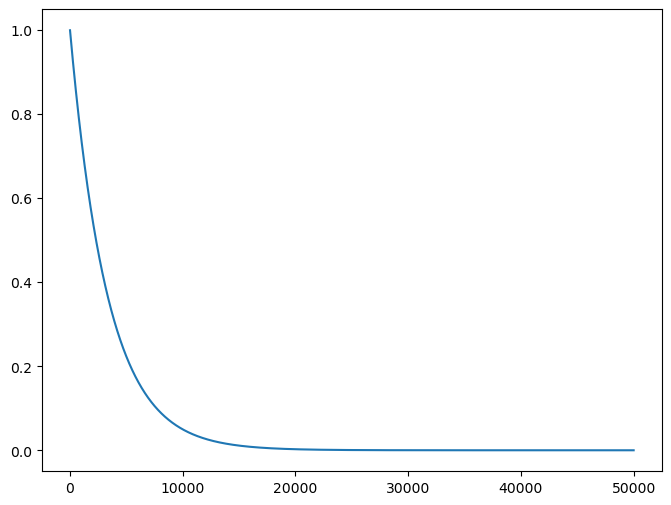

In [ ]:
import matplotlib.pyplot as plt

def decay_epsilon(epsilon):
    min_epsilon = 0.0001
    annealing_rate = 0.9997 # tốc độ giảm của epsilon
    epsilon = min_epsilon + annealing_rate * (epsilon - min_epsilon)
    return epsilon

epsilon = 1
y = []
for i in range(0,50000):
    epsilon = decay_epsilon(epsilon)
    y.append (epsilon)
x = range(0,50000)

plt.figure(figsize=(8,6))
plt.subplot(1,1,1)
plt.plot(x,y)


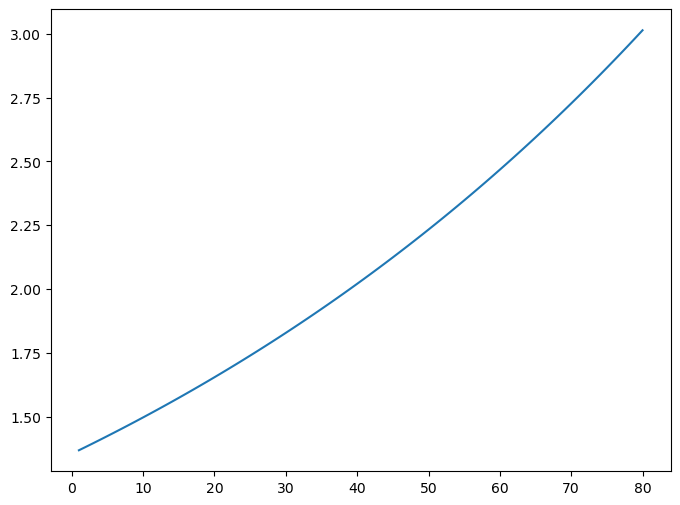

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np

def reward(delay_thres, delay, state, number_of_nodes):
    return 1/math.exp((delay_thres-delay)/number_of_nodes) + 1/math.exp((state - number_of_nodes)/number_of_nodes)

delay_threshold = 100
number_of_nodes = 100

state_arr = np.arange(100, 19, -1)
delay_arr = np.arange(0,80,1)

arr = []
for i, j in zip(state_arr, delay_arr):
    arr.append(reward(delay_threshold,j,i,number_of_nodes))

x = np.arange(1,81,1)

plt.figure(figsize=(8,6))
plt.subplot(1,1,1)
plt.plot(x,arr)


